In [14]:


import pandas as pd
import numpy as np
from pulp import *

# Load data

Shipping_info = pd.read_excel("/Users/arsenpankiv/Desktop/transportation_analytics/data.xlsx", sheet_name="Shipping information")
Lastmile_coords = pd.read_excel("/Users/arsenpankiv/Desktop/transportation_analytics/data.xlsx", sheet_name="Last mile coordinates")
Demand = pd.read_excel("/Users/arsenpankiv/Desktop/transportation_analytics/data.xlsx", sheet_name="Demands per product type")

# Sets
S = ['S1', 'S2', 'S3']  #supplier IDs
W = ['W1', 'W2', 'W3']  # warehouse IDs
D = ['DC1', 'DC2', 'DC3', 'DC4', 'DC5']  # Distribution centres
C = [f'C{i}' for i in range(1, 51)]  # Customer IDs
P = ['P1', 'P2', 'P3', 'P4', 'P5']
 

# Parameters
weight_p = {
    'P1': 7,
    'P2': 3,
    'P3': 5,
    'P4': 2,
    'P5': 8,

}

lastmilecost_p = {
    'P1': 0.06,
    'P2': 0.08,
    'P3': 0.03,
    'P4': 0.05,
    'P5': 0.11
}


# Demand (units)
demand_c_p = {
    (row['Customers'], product): row[product]
    for _, row in Demand.iterrows()
    for product in ['P1', 'P2', 'P3', 'P4', 'P5']
}

# Fixed and variable shipping costs
Shipping_info[['Origin', 'Destination']] = Shipping_info['Origin, Destination'].str.split(',', expand=True)
Shipping_info['Origin'] = Shipping_info['Origin'].str.strip()
Shipping_info['Destination'] = Shipping_info['Destination'].str.strip()


fixed_sd = {
    (row['Origin'], row['Destination']): row['Fixed cost']
    for _, row in Shipping_info.iterrows()
}

var_sd = {
    (row['Origin'], row['Destination']): row['Variable cost (per KG)']
    for _, row in Shipping_info.iterrows()
}

cap_sd = {
    (row['Origin'], row['Destination']): row['Capacity (KG)']
    for _, row in Shipping_info.iterrows()
}



coords_df = Lastmile_coords.set_index('DC_C')[['x', 'y']]


# Identify DCs and Customers based on their names
dc_names = [name for name in coords_df.index if name.startswith('DC')]
customer_names = [name for name in coords_df.index if name.startswith('C')]


# Calculate Euclidean distances between each DC and Customer 
dist_dc_c = {}
for d in dc_names:
    for c in customer_names:
        dx = coords_df.loc[d, 'x'] - coords_df.loc[c, 'x']
        dy = coords_df.loc[d, 'y'] - coords_df.loc[c, 'y']
        dist_dc_c[(d, c)] = (dx ** 2 + dy ** 2) ** 0.5

In [ ]:

# Model
model = LpProblem("SupplyChainOptimization", LpMinimize)

# Variables
x_swp = LpVariable.dicts("x_swp", ((s, w, p) for s in S for w in W for p in P), lowBound=0, cat='Integer')
x_wdp = LpVariable.dicts("x_wdp", ((w, d, p) for w in W for d in D for p in P), lowBound=0, cat='Integer')
x_dcp = LpVariable.dicts("x_dcp", ((d, c, p) for d in D for c in C for p in P), lowBound=0, cat='Integer')
y_sw = LpVariable.dicts("y_sw", ((s, w) for s in S for w in W), cat='Binary')
y_wd = LpVariable.dicts("y_wd", ((w, d) for w in W for d in D), cat='Binary')

# Objective
model += (
    lpSum(fixed_sd.get((s, w), 0) * y_sw[s, w] +
           lpSum(var_sd.get((s, w), 0) * x_swp[s, w, p] * weight_p[p] for p in P)
           for s in S for w in W) +
    lpSum(fixed_sd.get((w, d), 0) * y_wd[w, d] +
           lpSum(var_sd.get((w, d), 0) * x_wdp[w, d, p] * weight_p[p] for p in P)
           for w in W for d in D) +
    lpSum(x_dcp[d, c, p] * weight_p[p] * dist_dc_c[(d, c)] * lastmilecost_p[p]
           for d in D for c in C for p in P if (d, c) in dist_dc_c)
)



# Constraints
# Demand satisfaction
for c in C:
    for p in P:
        model += lpSum(x_dcp[d, c, p] for d in D) == demand_c_p[c, p]

# DC Flow balance
for d in D:
    for p in P:
        model += lpSum(x_wdp[w, d, p] for w in W) == lpSum(x_dcp[d, c, p] for c in C)

# Warehouse Flow balance
for w in W:
    for p in P:
        model += lpSum(x_swp[s, w, p] for s in S) == lpSum(x_wdp[w, d, p] for d in D)

# Capacity constraints
for s in S:
    for w in W:
        model += lpSum(x_swp[s, w, p] * weight_p[p] for p in P) <= cap_sd.get((s, w), 0) * y_sw[s, w]

for w in W:
    for d in D:
        model += lpSum(x_wdp[w, d, p] * weight_p[p] for p in P) <= cap_sd.get((w, d), 0) * y_wd[w, d]

# Route restrictions
model += y_sw['S2', 'W1'] == 0
for w_d in [('W1', 'DC4'), ('W1', 'DC5'), ('W2', 'DC2'), ('W3', 'DC1'), ('W3', 'DC2')]:
    model += y_wd[w_d] == 0
    
 ###### IMPORTANT !!!!!!!!!!   
 
'''AFTER: relaxing route restriction 
 Route restrictions:

    model += y_sw['S2', 'W1'] == 0
for w_d in []:
    model += y_wd[w_d] == 0  '''


# Customer-to-DC Allocation
groups = {
    'DC1': [f'C{i}' for i in range(1, 11)],
    'DC2': [f'C{i}' for i in range(11, 21)],
    'DC3': [f'C{i}' for i in range(21, 31)],
    'DC4': [f'C{i}' for i in range(31, 41)],
    'DC5': [f'C{i}' for i in range(41, 51)],
}

for d in D:
    for c in C:
        if c not in groups[d]:
            for p in P:
                model += x_dcp[d, c, p] == 0

# Solve
model.solve(PULP_CBC_CMD(msg=True))

# Output
print("Status:", LpStatus[model.status])
print("Total Cost:", value(model.objective))
for (s, w) in y_sw:
    if y_sw[s, w].varValue == 1:
        total_weight = sum(x_swp[s, w, p].varValue * weight_p[p] for p in P)
        print(f"Supplier {s} to Warehouse {w}: {total_weight:.2f} kg")
for (w, d) in y_wd:
    if y_wd[w, d].varValue == 1:
        total_weight = sum(x_wdp[w, d, p].varValue * weight_p[p] for p in P)
        print(f"Warehouse {w} to Distribution centre {d}: {total_weight:.2f} kg")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/yw/g9rc194541g7r9n119w4bljr0000gn/T/8d7f0ab09c174b3c92505e621208a632-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/yw/g9rc194541g7r9n119w4bljr0000gn/T/8d7f0ab09c174b3c92505e621208a632-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1325 COLUMNS
At line 9319 RHS
At line 10640 BOUNDS
At line 12032 ENDATA
Problem MODEL has 1320 rows, 1391 columns and 3841 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 801522 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 28 rows, 62 columns (62 integer (12 of which binary)) and 152 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 812692.

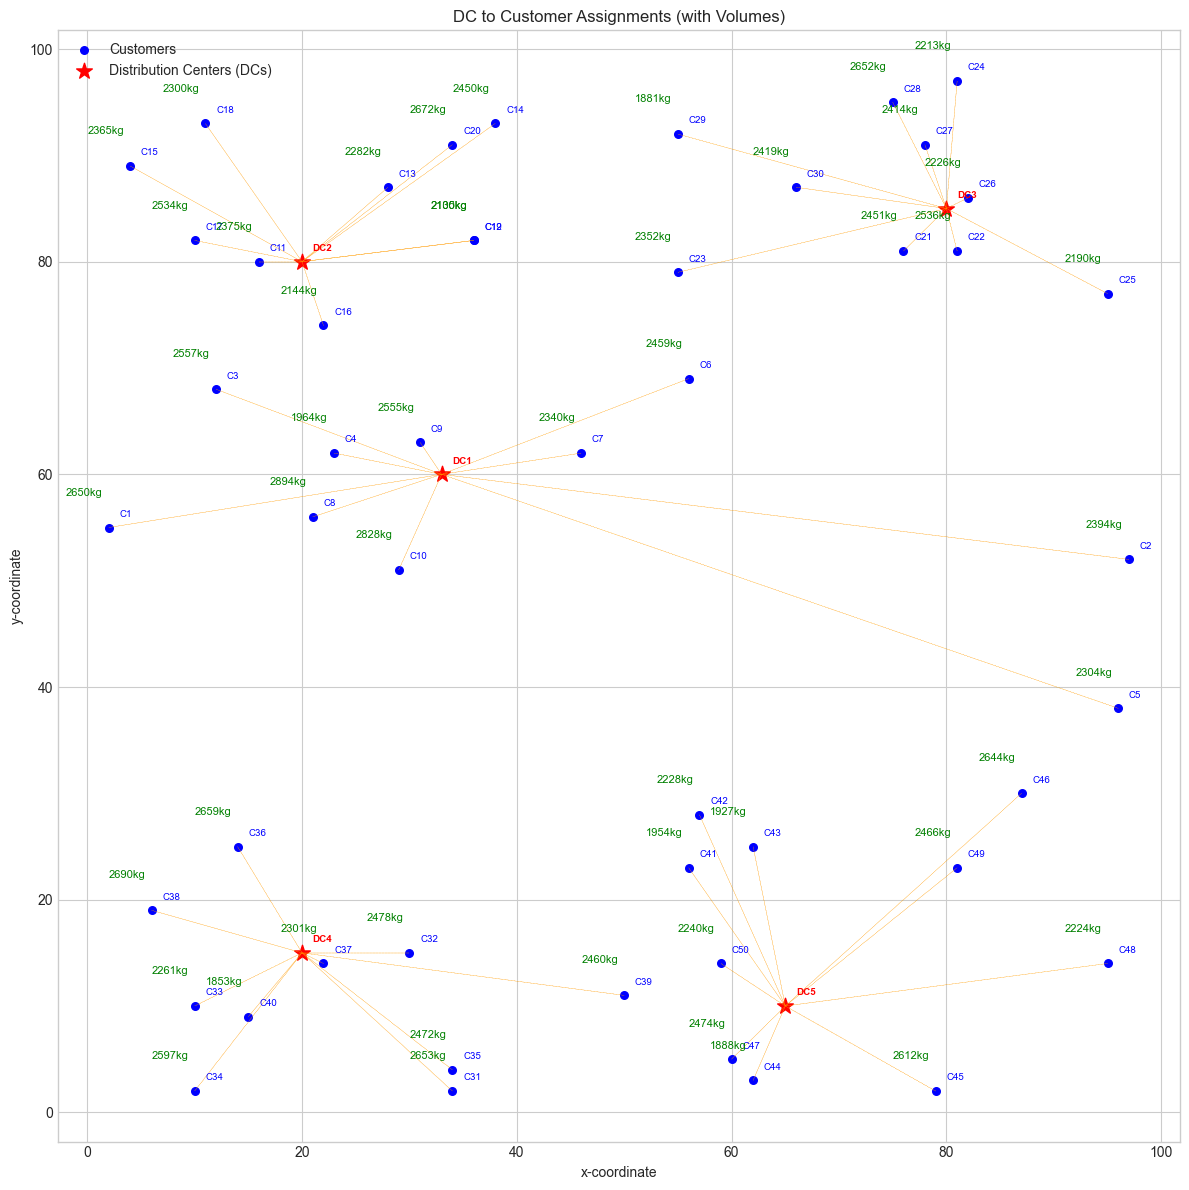

dict_items([(('DC1', 'C1', 'P1'), x_dcp_('DC1',_'C1',_'P1')), (('DC1', 'C1', 'P2'), x_dcp_('DC1',_'C1',_'P2')), (('DC1', 'C1', 'P3'), x_dcp_('DC1',_'C1',_'P3')), (('DC1', 'C1', 'P4'), x_dcp_('DC1',_'C1',_'P4')), (('DC1', 'C1', 'P5'), x_dcp_('DC1',_'C1',_'P5')), (('DC1', 'C2', 'P1'), x_dcp_('DC1',_'C2',_'P1')), (('DC1', 'C2', 'P2'), x_dcp_('DC1',_'C2',_'P2')), (('DC1', 'C2', 'P3'), x_dcp_('DC1',_'C2',_'P3')), (('DC1', 'C2', 'P4'), x_dcp_('DC1',_'C2',_'P4')), (('DC1', 'C2', 'P5'), x_dcp_('DC1',_'C2',_'P5')), (('DC1', 'C3', 'P1'), x_dcp_('DC1',_'C3',_'P1')), (('DC1', 'C3', 'P2'), x_dcp_('DC1',_'C3',_'P2')), (('DC1', 'C3', 'P3'), x_dcp_('DC1',_'C3',_'P3')), (('DC1', 'C3', 'P4'), x_dcp_('DC1',_'C3',_'P4')), (('DC1', 'C3', 'P5'), x_dcp_('DC1',_'C3',_'P5')), (('DC1', 'C4', 'P1'), x_dcp_('DC1',_'C4',_'P1')), (('DC1', 'C4', 'P2'), x_dcp_('DC1',_'C4',_'P2')), (('DC1', 'C4', 'P3'), x_dcp_('DC1',_'C4',_'P3')), (('DC1', 'C4', 'P4'), x_dcp_('DC1',_'C4',_'P4')), (('DC1', 'C4', 'P5'), x_dcp_('DC1',_'C

In [16]:

##### VISUALISATION 1

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# Prepare coordinates
coords_df = Lastmile_coords.set_index('DC_C')[['x', 'y']]
customer_coords = coords_df.loc[[name for name in coords_df.index if name.startswith('C')]]
dc_coords = coords_df.loc[[name for name in coords_df.index if name.startswith('DC')]]

plt.figure(figsize=(12, 12))

# Plot customers and DCs
plt.scatter(customer_coords['x'], customer_coords['y'], c='blue', label='Customers', s=30)
plt.scatter(dc_coords['x'], dc_coords['y'], c='red', label='Distribution Centers (DCs)', s=140, marker='*')

# Annotate nodes
for name, row in customer_coords.iterrows():
    plt.text(row['x'] + 1, row['y'] + 1, name, fontsize=7, color='blue')
for name, row in dc_coords.iterrows():
    plt.text(row['x'] + 1, row['y'] + 1, name, fontsize=7, color='red', weight='bold')

# Compute total volume per customer and draw arrows
customer_volumes = {}

for (d, c, p), var in x_dcp.items():
    if var.varValue > 0:
        volume = var.varValue * weight_p[p]
        customer_volumes[c] = customer_volumes.get(c, 0) + volume

        # Draw arrow from DC to customer
        x_dc, y_dc = coords_df.loc[d, 'x'], coords_df.loc[d, 'y']
        x_c, y_c = coords_df.loc[c, 'x'], coords_df.loc[c, 'y']
        plt.arrow(x_dc, y_dc, x_c - x_dc, y_c - y_dc,
                  length_includes_head=False, head_width=0,
                  alpha=0.2, color='orange', linestyle='--',linewidth=0.2)

# Label total volume near each customer (once)
for c, total_vol in customer_volumes.items():
    x_c, y_c = coords_df.loc[c, 'x'], coords_df.loc[c, 'y']
    plt.text(x_c - 4, y_c + 3, f"{int(total_vol)}kg",
             fontsize=8, color='green', alpha=1)

# Final plot settings
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('DC to Customer Assignments (with Volumes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(x_dcp.items())


#  C1 (2650 kg) = P1D * P1W +P2D * P2W + P3D * P3W + P4D * P4W + P5D * P5W


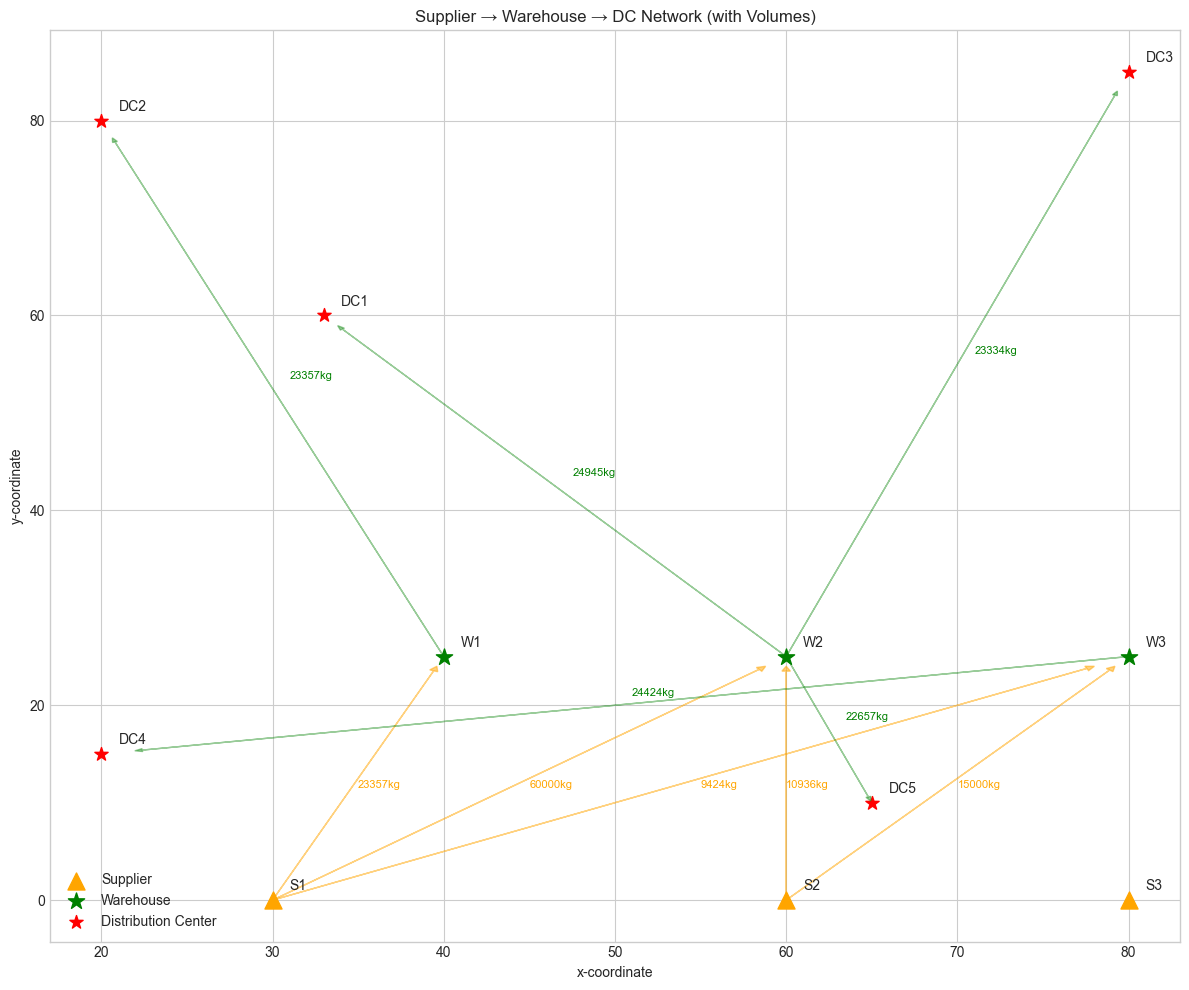

In [17]:
# VISUALISATION 2

import matplotlib.pyplot as plt
import pandas as pd

# Mock supplier and warehouse coordinates 
supplier_coords = {
    'S1': (30, 0),
    'S2': (60, 0),
    'S3': (80, 0)
}

warehouse_coords = {
    'W1': (40, 25),
    'W2': (60, 25),
    'W3': (80, 25)
}

# Load real DC coordinates
coords_df = Lastmile_coords.set_index('DC_C')[['x', 'y']]
dc_plot_coords = {dc: (coords_df.loc[dc, 'x'], coords_df.loc[dc, 'y']) for dc in D}

plt.figure(figsize=(12, 10))

# Plot suppliers
for s, (x, y) in supplier_coords.items():
    plt.scatter(x, y, c='orange', s=150, marker='^', label='Supplier' if s == 'S1' else "")
    plt.text(x + 1, y + 1, s, fontsize=10)

# Plot warehouses
for w, (x, y) in warehouse_coords.items():
    plt.scatter(x, y, c='green', s=150, marker='*', label='Warehouse' if w == 'W1' else "")
    plt.text(x + 1, y + 1, w, fontsize=10)

# Plot DCs
for d, (x, y) in dc_plot_coords.items():
    plt.scatter(x, y, c='red', s=100, marker='*', label='Distribution Center' if d == 'DC1' else "")
    plt.text(x + 1, y + 1, d, fontsize=10)

# Arrows: Supplier - Warehouse
for s in S:
    for w in W:
        total_weight = sum(x_swp[s, w, p].varValue * weight_p[p] for p in P if x_swp[s, w, p].varValue > 0)
        if total_weight > 0:
            x_s, y_s = supplier_coords[s]
            x_w, y_w = warehouse_coords[w]
            plt.arrow(x_s, y_s, (x_w - x_s)*0.96, (y_w - y_s)*0.96,
                      length_includes_head=True, head_width=0.5, head_length=0.5,
                      linewidth=1, color='orange', alpha=0.5)
            mid_x = (x_s + x_w) / 2
            mid_y = (y_s + y_w) / 2
            plt.text(mid_x, mid_y-1, f"{int(total_weight)}kg", fontsize=8, color='orange')

# Arrows: Warehouse - DC
for w in W:
    for d in D:
        total_weight = sum(x_wdp[w, d, p].varValue * weight_p[p] for p in P if x_wdp[w, d, p].varValue > 0)
        if total_weight > 0:
            x_w, y_w = warehouse_coords[w]
            x_d, y_d = dc_plot_coords[d]
            plt.arrow(x_w, y_w, (x_d - x_w)*0.96, (y_d - y_w)*0.96,
                      length_includes_head=False
                      , head_width=0.3, alpha=0.4, color='green')
            mid_x = (x_w + x_d) / 2
            mid_y = (y_w + y_d) / 2
            plt.text(mid_x+1, mid_y+1, f"{int(total_weight)}kg", fontsize=8, color='green')

# Finishing touches
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Supplier → Warehouse → DC Network (with Volumes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



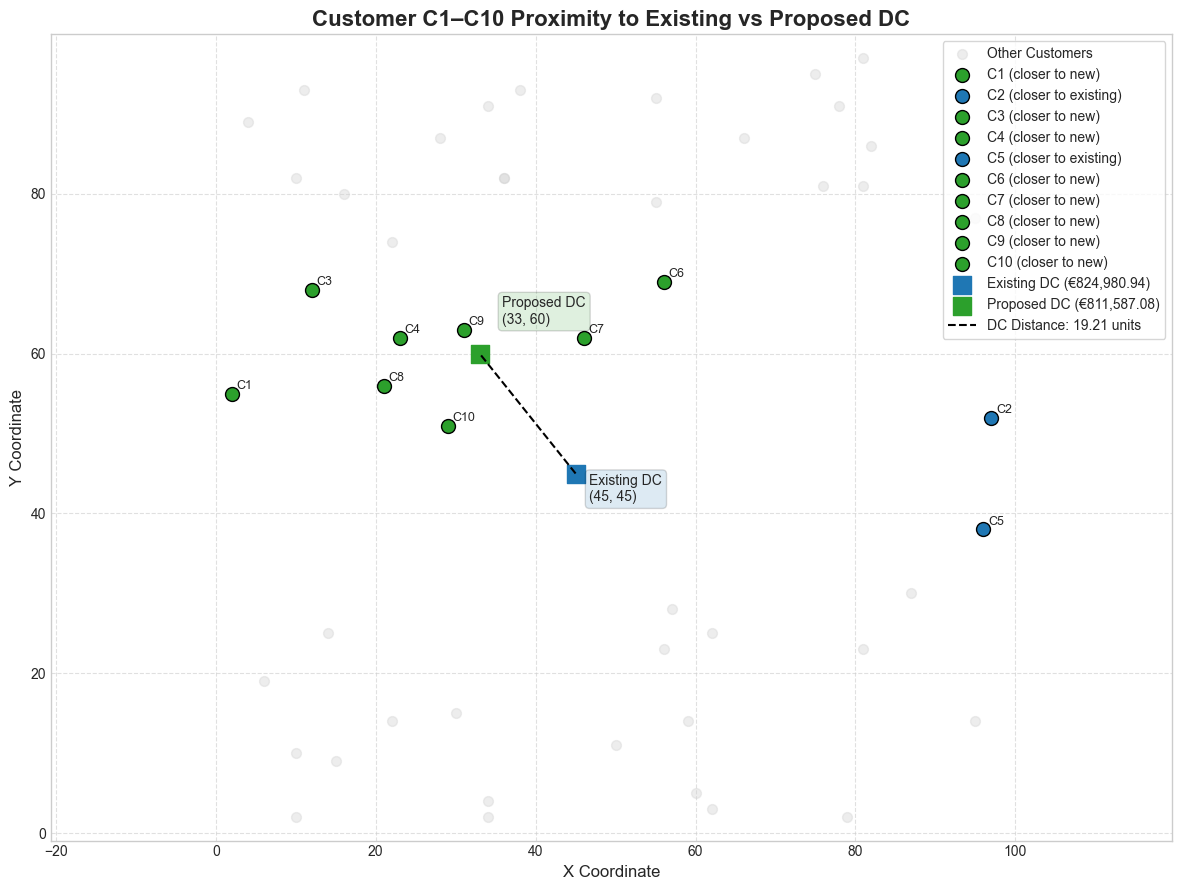

Customer C1–C10 Distance Comparison:
      dist_to_existing  dist_to_new closer_to
DC_C                                         
C1               44.15        31.40       new
C2               52.47        64.50  existing
C3               40.22        22.47       new
C4               27.80        10.20       new
C5               51.48        66.73  existing
C6               26.40        24.70       new
C7               17.03        13.15       new
C8               26.40        12.65       new
C9               22.80         3.61       new
C10              17.09         9.85       new


In [18]:
#  VISUALIZATION FOR RECOMMENDATION(2)


import matplotlib.pyplot as plt
import math
import pandas as pd

# Subset of customers C1–C10
subset_customers = [f'C{i}' for i in range(1, 11)]
subset_coords = coords_df.loc[subset_customers].copy()

# Define DCs
existing_dc = {'name': 'Existing DC', 'x': 45, 'y': 45, 'color': '#1f77b4', 'cost': 824980.94}
new_dc = {'name': 'Proposed DC', 'x': 33, 'y': 60, 'color': '#2ca02c', 'cost': 811587.08}

# Euclidean distance between DCs
distance = math.sqrt((existing_dc['x'] - new_dc['x'])**2 + (existing_dc['y'] - new_dc['y'])**2)

# Compute distances and determine closer DC
subset_coords['dist_to_existing'] = ((subset_coords['x'] - existing_dc['x'])**2 + (subset_coords['y'] - existing_dc['y'])**2)**0.5
subset_coords['dist_to_new'] = ((subset_coords['x'] - new_dc['x'])**2 + (subset_coords['y'] - new_dc['y'])**2)**0.5
subset_coords['closer_to'] = subset_coords.apply(lambda row: 'new' if row['dist_to_new'] < row['dist_to_existing'] else 'existing', axis=1)

# Plot
plt.figure(figsize=(12, 9))
plt.style.use("seaborn-v0_8-whitegrid")

# Plot all customers 
plt.scatter(coords_df.loc[coords_df.index.str.startswith('C'), 'x'], 
            coords_df.loc[coords_df.index.str.startswith('C'), 'y'], 
            color='lightgray', s=50, label='Other Customers', alpha=0.4)

# Highlight C1–C10 based on proximity
for idx, row in subset_coords.iterrows():
    color = new_dc['color'] if row['closer_to'] == 'new' else existing_dc['color']
    plt.scatter(row['x'], row['y'], color=color, s=100, edgecolor='black', label=f"{idx} (closer to {row['closer_to']})")
    plt.text(row['x'] + 0.6, row['y'] + 0.6, idx, fontsize=9)

# Plot DCs
plt.scatter(existing_dc['x'], existing_dc['y'], color=existing_dc['color'], s=180, marker='s',
            label=f"{existing_dc['name']} (€{existing_dc['cost']:,.2f})")
plt.scatter(new_dc['x'], new_dc['y'], color=new_dc['color'], s=180, marker='s',
            label=f"{new_dc['name']} (€{new_dc['cost']:,.2f})")

# Connect DCs
plt.plot([existing_dc['x'], new_dc['x']], [existing_dc['y'], new_dc['y']],
         'k--', linewidth=1.5, label=f"DC Distance: {distance:.2f} units")

# Annotate DCs
plt.annotate(f"{existing_dc['name']}\n({existing_dc['x']}, {existing_dc['y']})",
             (existing_dc['x'], existing_dc['y']),
             textcoords="offset points", xytext=(10, -20), ha='left',
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc=existing_dc['color'], alpha=0.15))

plt.annotate(f"{new_dc['name']}\n({new_dc['x']}, {new_dc['y']})",
             (new_dc['x']+15, new_dc['y']+2),
             textcoords="offset points", xytext=(-70, 10), ha='left',
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc=new_dc['color'], alpha=0.15))

# Final touches
plt.title("Customer C1–C10 Proximity to Existing vs Proposed DC", fontsize=16, weight='bold')
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)
plt.axis('equal')
plt.legend(fontsize=10, loc='upper right', frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Print customer comparison table
print("Customer C1–C10 Distance Comparison:")
print(subset_coords[['dist_to_existing', 'dist_to_new', 'closer_to']].round(2))